In [19]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

### **Load the data**

In [20]:
from torch.utils.data import random_split

# 指定数据路径
data_dir = r'C:\Users\rache\Downloads\archive'

# 定义图像转换操作
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # 调整图像大小
    transforms.ToTensor(),          # 转换为张量
])

# 加载所有的图像数据
data = datasets.ImageFolder(root=data_dir, transform=transform)

# 定义训练集和测试集的大小
train_size = int(0.8 * len(data))  # 80%的数据用于训练
test_size = len(data) - train_size  # 剩余的数据用于测试

# 使用random_split来分割数据
train_data, test_data = random_split(data, [train_size, test_size])

In [21]:
# 打印训练数据的总数
print(f'Total number of training examples: {len(train_data)}')

# 打印类别到索引的映射
print(f'Class to index mapping: {train_data.dataset.class_to_idx}')

# 打印第一个样本的形状
print(f'Shape of the first example: {train_data[0][0].shape}')

# 打印第一个样本的标签
print(f'Label of the first example: {train_data[0][1]}')

Total number of training examples: 1984
Class to index mapping: {'COVID': 0, 'non-COVID': 1}
Shape of the first example: torch.Size([3, 128, 128])
Label of the first example: 0


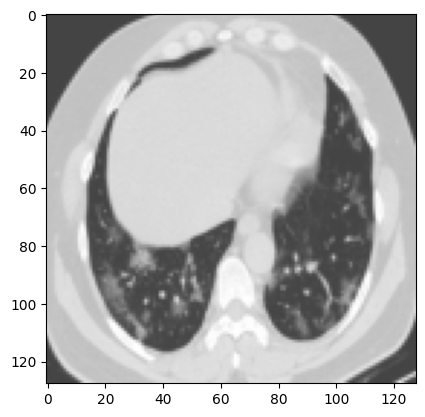

In [22]:
# Show some images
import matplotlib.pyplot as plt
plt.imshow(train_data[0][0].permute(1, 2, 0))


In [23]:
# Put the data into DataLoader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)

### **Build a CNN model**

Remember:
$$ H_{out} = \frac{H_{in}-kernel\_size + 2*padding}{stride} + 1$$
$$ W_{out} = \frac{W_{in}-kernel\_size + 2*padding}{stride} + 1$$

In [24]:
# Design a CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=9, stride=1, padding=0) 
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=9, stride=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=9, stride=1, padding=0)
        self.fc1 = nn.Linear(32*9*9, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x)) # output shape: (8, 122, 122)
        x = self.pool(x) # output shape: (8, 61, 61)
        x = F.relu(self.conv2(x)) # output shape: (16, 55, 55)
        x = self.pool(x) # output shape: (16, 27, 27)
        x = F.relu(self.conv3(x)) # output shape: (32, 21, 21)
        x = self.pool(x) # output shape: (32, 10, 10)
        x = x.view(x.size(0), -1)  # flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [25]:
from sklearn.metrics import roc_auc_score

def evaluate_model(model, dataloader):
    model.eval()  # 设置模型为评估模式
    outputs = []
    targets = []

    with torch.no_grad():  # 不需要计算梯度
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            output = model(inputs)
            outputs.extend(output.detach().cpu().numpy())
            targets.extend(labels.detach().cpu().numpy())

    # 计算AUC
    auc = roc_auc_score(targets, outputs)

    return auc

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu'))

#Initialize the model, loss function and optimizer
cnn = CNN().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)

###  **Train the data**

In [27]:
def main(n_epochs, model, loss, optimizer, train_loader, test_loader):
    training_loss = []
    testing_loss = []
    testing_accuracy = []
    testing_auc = []  # 存储每个epoch的AUC
    best_accuracy = 0.0
    best_auc = 0.0

    for epoch in range(1, n_epochs+1):
        # Training
        running_loss = 0.0
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss_val = loss(outputs, labels)
            loss_val.backward()
            optimizer.step()

            running_loss += loss_val.item()

        train_loss = running_loss / len(train_loader)
        training_loss.append(train_loss)

        # Testing
        model.eval()
        eval_loss = 0.0
        correct = 0
        total = 0
        all_preds = []  # 存储所有的预测分数
        all_labels = []  # 存储所有的真实标签

        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)
                pred = torch.argmax(outputs, 1)
                test_loss = loss(outputs, labels)
                eval_loss += test_loss.item()

                all_preds.extend(outputs[:, 1].cpu().numpy())  # 收集预测分数
                all_labels.extend(labels.cpu().numpy())  # 收集真实标签

            total += labels.size(0)
            correct += (pred == labels).sum().item()
        
        test_loss = eval_loss / len(test_loader)
        testing_loss.append(test_loss)
        accuracy = correct / total
        testing_accuracy.append(accuracy)

        # 计算AUC
        auc = roc_auc_score(all_labels, all_preds)
        testing_auc.append(auc)

        # Save the best model
        if epoch == 1:
            best_accuracy = accuracy
            best_auc = auc
        else:
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_auc = auc
                torch.save(model.state_dict(), 'best_model.pth')

        if epoch % 5 == 0:
            print(f'Epoch {epoch}/{n_epochs}, Training Loss: {train_loss:.4f}, Testing Loss: {test_loss:.4f}, Testing Accuracy: {accuracy:.4f}, Testing AUC: {auc:.4f}')

    print('The best accuracy is:', best_accuracy)
    print('The corresponding AUC is:', best_auc)

    return training_loss, testing_loss, testing_accuracy, testing_auc

In [76]:
training_loss, testing_loss, testing_accuracy, testing_auc = main(30, cnn, criterion, optimizer, train_loader, test_loader)

KeyboardInterrupt: 

# Plot the training and testing loss
def plot(training_loss, testing_loss, testing_accuracy):
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    plt.plot(training_loss, label='Training Loss')
    plt.plot(testing_loss, label='Testing Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.xlabel('Epoch')
    plt.ylabel('Testing Accuracy')
    plt.plot(testing_accuracy)
    plt.show()

plot(training_loss, testing_loss, testing_accuracy)

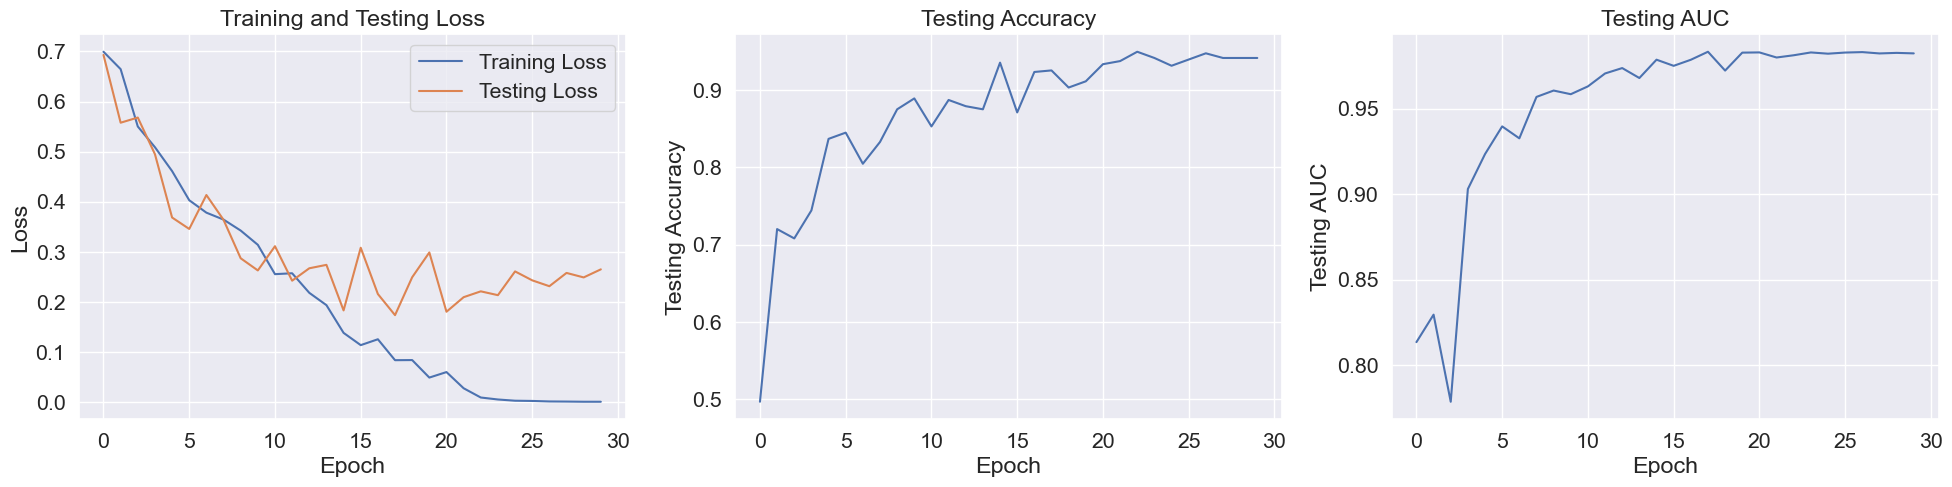

In [82]:
import matplotlib.pyplot as plt

# Plot the training and testing loss and AUC
def plot(training_loss, testing_loss, testing_accuracy, testing_auc):
    plt.figure(figsize=(24, 5))

    plt.subplot(1, 3, 1)
    plt.plot(training_loss, label='Training Loss')
    plt.plot(testing_loss, label='Testing Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.xlabel('Epoch')
    plt.ylabel('Testing Accuracy')
    plt.plot(testing_accuracy)
    plt.title('Testing Accuracy')

    plt.subplot(1, 3, 3)
    plt.xlabel('Epoch')
    plt.ylabel('Testing AUC')
    plt.plot(testing_auc)
    plt.title('Testing AUC')

    plt.show()

# Assuming these variables are already defined and hold the data
# training_loss, testing_loss, testing_accuracy, testing_auc

# Call the plot function with your data
plot(training_loss, testing_loss, testing_accuracy, testing_auc)


### **Load Pre-trained Models**

In [34]:
from torchvision.models import resnet50
resnet = resnet50(pretrained=True)
resnet.fc = nn.Linear(2048, 4)


In [35]:
resnet = resnet.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.001)

In [36]:
resnet.eval()

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = resnet(images)
    pred = torch.argmax(outputs, 1)
    print('Predicted:', pred)
    print('Ground Truth:', labels)
    print('Accuracy:', (pred == labels).sum().item() / labels.size(0))
    break

Predicted: tensor([0, 0, 0, 1, 0, 1, 2, 2, 0, 0, 0, 0, 0, 1, 0, 1, 1, 2, 0, 0, 0, 1, 2, 1,
        1, 1, 0, 0, 2, 0, 1, 1], device='cuda:0')
Ground Truth: tensor([0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
        0, 0, 0, 0, 1, 0, 1, 1], device='cuda:0')
Accuracy: 0.53125


## ResNet


In [77]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score
import numpy as np

# 使用预训练的ResNet18模型
model = models.resnet18(pretrained=True)
model.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=2)

# 将模型移动到GPU（如果可用）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 20
best_accuracy = 0.0
best_auc = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_probs = []
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Save prediction probabilities and true labels
        probs = torch.softmax(outputs.detach(), dim=1)[:, 1].cpu().numpy()
        all_probs.extend(probs)
        all_labels.extend(labels.cpu().numpy())

    train_accuracy = 100 * correct / total
    train_auc = roc_auc_score(all_labels, all_probs)
    
    if (epoch + 1) % 5 == 0:
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_probs = []
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                # 保存预测概率和真实标签
                probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
                all_probs.extend(probs)
                all_labels.extend(labels.cpu().numpy())

        test_accuracy = 100 * correct / total
        test_auc = roc_auc_score(all_labels, all_probs)
        
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_auc = test_auc
        
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Training Loss: {running_loss/len(train_loader):.4f}, "
              f"Testing Loss: {test_loss/len(test_loader):.4f}, "
              f"Testing Accuracy: {test_accuracy:.2f}%, "
              f"AUC: {test_auc:.4f}")

print(f'Best Accuracy on test data: {best_accuracy:.2f}%, Best AUC: {best_auc:.4f}')

c:\Users\rache\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\rache\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [5/20], Training Loss: 0.0961, Testing Loss: 0.4042, Testing Accuracy: 88.73%, AUC: 0.9679
Epoch [10/20], Training Loss: 0.0212, Testing Loss: 0.1988, Testing Accuracy: 94.16%, AUC: 0.9953
Epoch [15/20], Training Loss: 0.0262, Testing Loss: 0.6869, Testing Accuracy: 79.48%, AUC: 0.9877
Epoch [20/20], Training Loss: 0.0081, Testing Loss: 0.1042, Testing Accuracy: 96.98%, AUC: 0.9948
Best Accuracy on test data: 96.98%, Best AUC: 0.9948


Epoch 1/20, Training Loss: 0.4308, Testing Loss: 0.2215, Testing Accuracy: 0.9437, Testing AUC: 0.9823
Epoch 2/20, Training Loss: 0.2341, Testing Loss: 0.4156, Testing Accuracy: 0.8551, Testing AUC: 0.9719
Epoch 3/20, Training Loss: 0.1377, Testing Loss: 0.1495, Testing Accuracy: 0.9416, Testing AUC: 0.9876
Epoch 4/20, Training Loss: 0.1194, Testing Loss: 0.9185, Testing Accuracy: 0.7203, Testing AUC: 0.9784
Epoch 5/20, Training Loss: 0.0670, Testing Loss: 1.5899, Testing Accuracy: 0.7384, Testing AUC: 0.8481
Epoch 6/20, Training Loss: 0.0919, Testing Loss: 1.5722, Testing Accuracy: 0.6097, Testing AUC: 0.6245
Epoch 7/20, Training Loss: 0.0968, Testing Loss: 0.1089, Testing Accuracy: 0.9618, Testing AUC: 0.9930
Epoch 8/20, Training Loss: 0.0316, Testing Loss: 0.0965, Testing Accuracy: 0.9678, Testing AUC: 0.9956
Epoch 9/20, Training Loss: 0.0614, Testing Loss: 0.1878, Testing Accuracy: 0.9336, Testing AUC: 0.9884
Epoch 10/20, Training Loss: 0.0375, Testing Loss: 0.2162, Testing Accurac

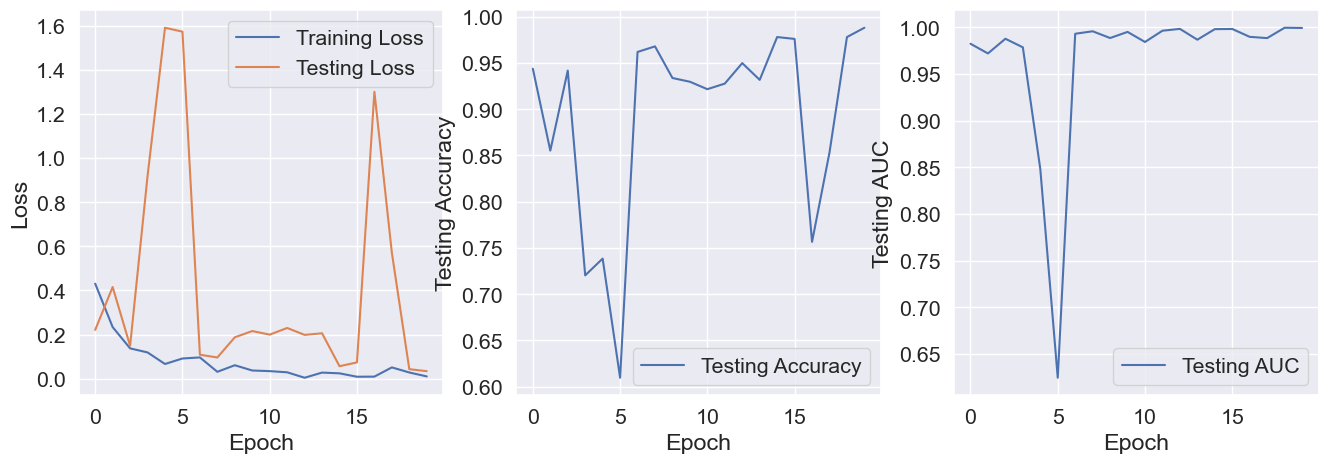

In [87]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import numpy as np

# 使用预训练的ResNet18模型
model = models.resnet18(pretrained=True)
model.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=2)

# 将模型移动到GPU（如果可用）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 定义训练和测试函数
def main(n_epochs, model, loss, optimizer, train_loader, test_loader):
    training_loss = []
    testing_loss = []
    testing_accuracy = []
    testing_auc = []

    best_accuracy = 0.0

    for epoch in range(1, n_epochs+1):
        # Training
        running_loss = 0.0
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss_val = loss(outputs, labels)
            loss_val.backward()
            optimizer.step()

            running_loss += loss_val.item()

        train_loss = running_loss / len(train_loader)
        training_loss.append(train_loss)

        # Testing
        model.eval()
        eval_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_outputs = []

        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)
                pred = torch.argmax(outputs, 1)
                test_loss = loss(outputs, labels)
                eval_loss += test_loss.item()

            total += labels.size(0)
            correct += (pred == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())
            all_outputs.extend(outputs.cpu().numpy()[:, 1])

        test_loss = eval_loss / len(test_loader)
        testing_loss.append(test_loss)
        accuracy = correct / total
        testing_accuracy.append(accuracy)
        
        # Calculate AUC
        auc = roc_auc_score(all_labels, all_outputs)
        testing_auc.append(auc)

        # Save the best model
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), 'best_model.pth')

        print(f'Epoch {epoch}/{n_epochs}, Training Loss: {train_loss:.4f}, Testing Loss: {test_loss:.4f}, Testing Accuracy: {accuracy:.4f}, Testing AUC: {auc:.4f}')

    print('The best accuracy is:', best_accuracy)

    return training_loss, testing_loss, testing_accuracy, testing_auc

# 训练和测试ResNet模型
training_loss, testing_loss, testing_accuracy, testing_auc = main(20, model, criterion, optimizer, train_loader, test_loader)

# 绘制训练和测试损失，以及测试准确率和AUC
def plot(training_loss, testing_loss, testing_accuracy, testing_auc):
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 3, 1)
    plt.plot(training_loss, label='Training Loss')
    plt.plot(testing_loss, label='Testing Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(testing_accuracy, label='Testing Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Testing Accuracy')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.plot(testing_auc, label='Testing AUC')
    plt.xlabel('Epoch')
    plt.ylabel('Testing AUC')
    plt.legend()

    plt.show()

plot(training_loss, testing_loss, testing_accuracy, testing_auc)
